<a href="https://colab.research.google.com/github/codeavenger456/MNIST_Max-digits/blob/main/Finished_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
! kaggle competitions download -c mais-202-fall-2020-kaggle-competition

  0% 0.00/341k [00:00<?, ?B/s]
100% 341k/341k [00:00<00:00, 24.6MB/s]
 98% 193M/196M [00:10<00:00, 16.4MB/s]
100% 196M/196M [00:10<00:00, 19.9MB/s]
100% 781M/784M [02:01<00:00, 4.71MB/s]
100% 784M/784M [02:01<00:00, 6.74MB/s]


In [5]:
! unzip train_x.npy.zip
! unzip test_x.npy.zip

Archive:  train_x.npy.zip
  inflating: train_x.npy             
Archive:  test_x.npy.zip
  inflating: test_x.npy              


In [1]:
import numpy as np
train_images = np.load("train_x.npy")

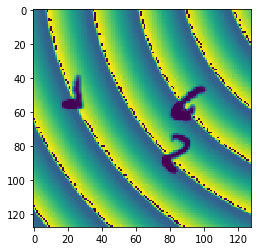

In [2]:
import matplotlib.pyplot as plt

def show_image(arr):
    two_d = (np.reshape(arr, (128, 128)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest')
    plt.show()

show_image(train_images[0]) # 0 is the index of the training image you want to display

Import Libraries 

In [3]:
import cv2
import numpy as np
import pandas as pd
from keras.layers import Dense, Flatten, BatchNormalization, Activation, MaxPool2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split

# New Section

Get our Dataset 

In [4]:
# x_train = np.load('train_x.npy') 
# use train_image instead it x_train has been previously loaded
y_train = pd.read_csv('train_y.csv')
#discard the Id column from the np array we dont need it
y_train = y_train["Label"]
x_test = np.load('test_x.npy')
# the batch picture generator only takes in categorical tuple data for some reason so we will do this
y_train = to_categorical(y_train)

In [5]:
#remove noise
new_train = []
def denoise(image):
  ret,th1 = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)
  return th1

In [6]:
# this denoises the entire inputset
for i in train_images:
  new_train.append(denoise(i))
train_images = np.array(new_train)
del new_train

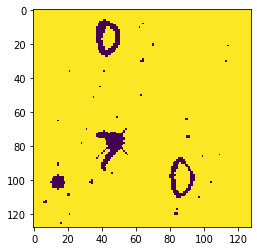

In [7]:
show_image(train_images[1])

In [8]:
# imagedatagenerator only takes in 4d data so we need to add an extra dimension to our data
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

Shuffle training dataset

In [20]:
np.random.shuffle(train_images)

Split training dataset into training and validation dataset

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, y_train, test_size=0.1)

Data Augmentation by ImageDataGenerator

In [10]:
#flipping is not applicable here because it changes numbers
#All the params below are randomly selected, no particular reasons behind any of the selections
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15
)
datagen.fit(X_train)

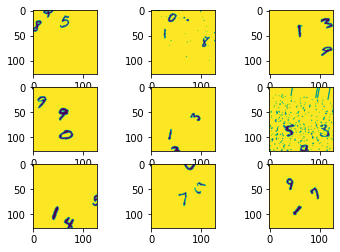

In [11]:
## below is an example of the batch data geneartion
## use " datagen.flow(train_images, y_train, batch_size=?) " to generate picture data
for X_batch, y_batch in datagen.flow(X_train, Y_train, batch_size=9):
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(128, 128))
	# show the plot
	plt.show()
	break

CNN network

In [12]:
model = Sequential()
    
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(128, 128, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        1

In [13]:
model.compile(loss="categorical_crossentropy", optimizer=RMSprop(), metrics=['accuracy'])
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=200), validation_data=(X_val, Y_val), epochs=30)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
180/180 [==============================] - 153s 853ms/step - loss: 2.6389 - accuracy: 0.2534 - val_loss: 2.6008 - val_accuracy: 0.2450
Epoch 2/30
180/180 [==============================] - 154s 855ms/step - loss: 1.6870 - accuracy: 0.3838 - val_loss: 4.8176 - val_accuracy: 0.2250
Epoch 3/30
180/180 [==============================] - 153s 850ms/step - loss: 1.3444 - accuracy: 0.5482 - val_loss: 1.6616 - val_accuracy: 0.3192
Epoch 4/30
180/180 [==============================] - 153s 850ms/step - loss: 1.0985 - accuracy: 0.6358 - val_loss: 1.0416 - val_accuracy: 0.6935
Epoch 5/30
180/180 [==============================] - 153s 850ms/step - loss: 0.8976 - accuracy: 0.7167 - val_loss: 2.1951 - val_accuracy: 0.6850
Epoch 6/30
180/180 [==============================] - 153s 850ms/step - loss: 0.8013 - accuracy: 0.7553 - val_loss: 0.5998 - val_accuracy: 0.8413
Epoch 7/30
180/180 [============================

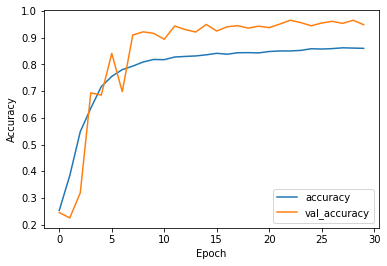

In [14]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Predicting the results

In [20]:
labels_probabilities = model.predict(x_test)
labels = np.argmax(labels_probabilities, axis=-1)
print(labels)

[9 9 9 ... 9 9 9]


See the predictions

In [24]:
for i in labels:
  print(i)

7
5
7
7
7


Put in CSV

In [26]:
ids = [i for i in range(len(labels))]
ids = np.array(ids)

[   0    1    2 ... 9997 9998 9999]
